# TUTORIAL OF TENSORFLOW API 05
## WITHOUT TRANSFER LEARNING (BASIC ARCHITECTURE)
## TRANSFER LEARNING

In [38]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import random
import math
import shutil

## Connect to Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## BASIC ARCHITECTURE

## 1_Load dataset

In [20]:
BASE_DIR = '/content/drive/MyDrive/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [21]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [ ]:
# Moce the image files
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

## 2_Normalize dataset with optinal data augmentation if needed

In [23]:
# Generate batches of tensor image data with optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# Optinal for data augumentation
#    rotation_range=20,
#    horizontal_flip=True,
#    width_shift_range=0.2, height_shift_range=0.2,
#    shear_range=0.2, zoom_range=0.2)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


## 3_Train,Validation,Test split

In [33]:
train_batches = train_gen.flow_from_directory(
    BASE_DIR+'/train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR+'/val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR+'/test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)


Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [34]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[1. 3. 1. 4.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


## 4_Plot to visualize some examples dataset

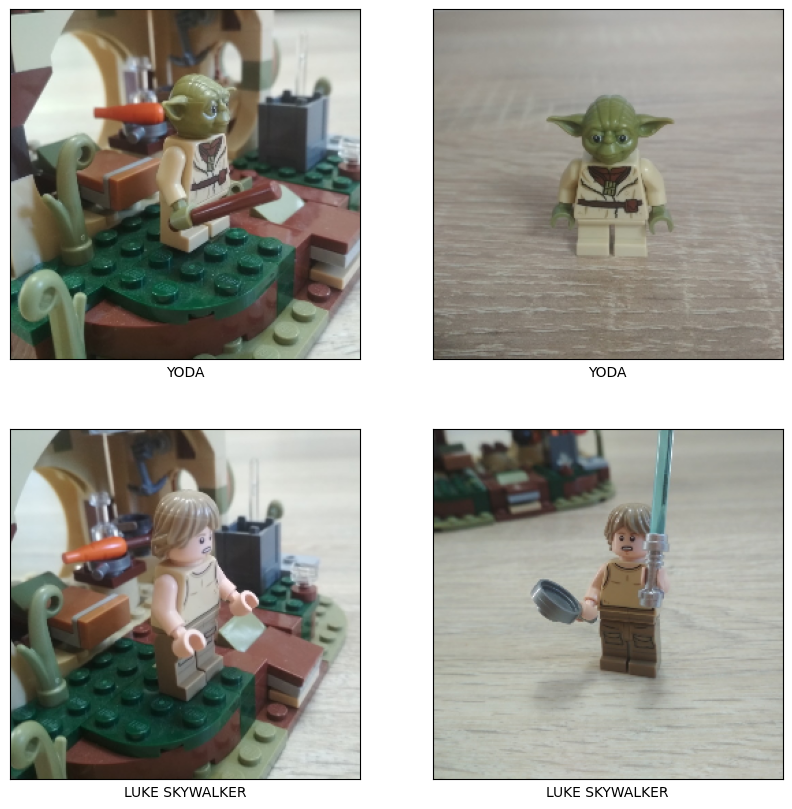

In [35]:
def show_examples(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays,
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show_examples(test_batch)

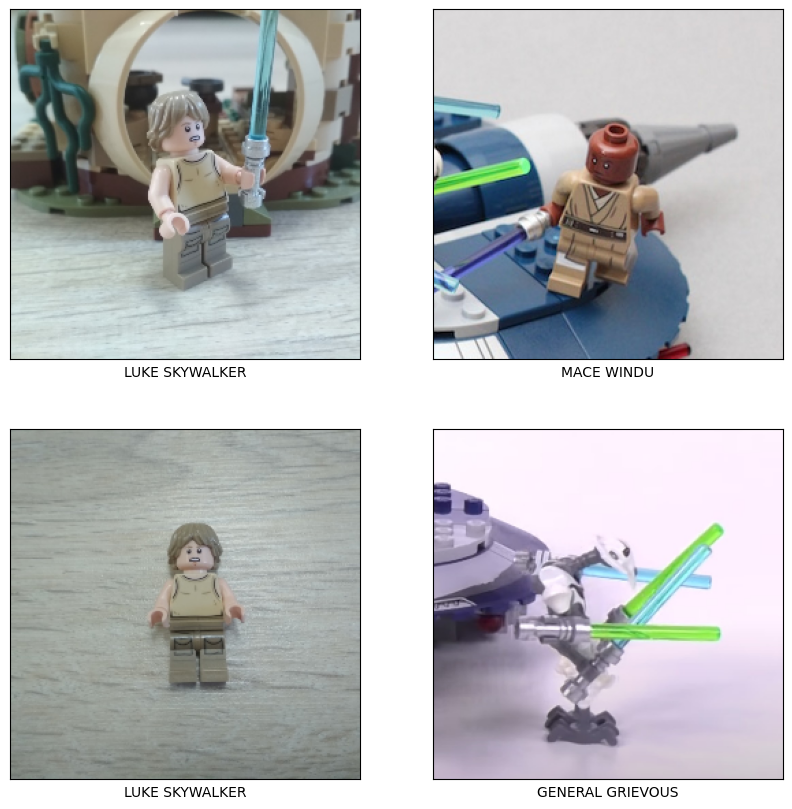

In [36]:
show_examples(train_batch)

## 5_Build Model

In [1]:
model = Sequential()
model.add(Input(shape=(256, 256,3)))
model.add(Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5))
print(model.summary())

NameError: name 'Sequential' is not defined

## 6_Select Hyperparameters for Model

In [41]:
# loss and optimizer
loss = SparseCategoricalCrossentropy(from_logits=True)
optim = Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [42]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[early_stopping],
    epochs=epochs,
    verbose=2
)

Epoch 1/30
10/10 - 17s - loss: 15.1045 - accuracy: 0.1892 - val_loss: 2.1130 - val_accuracy: 0.1875 - 17s/epoch - 2s/step
Epoch 2/30
10/10 - 10s - loss: 1.9032 - accuracy: 0.1351 - val_loss: 1.5852 - val_accuracy: 0.1875 - 10s/epoch - 976ms/step
Epoch 3/30
10/10 - 7s - loss: 1.5383 - accuracy: 0.3514 - val_loss: 1.5578 - val_accuracy: 0.3125 - 7s/epoch - 708ms/step
Epoch 4/30
10/10 - 9s - loss: 1.3128 - accuracy: 0.6216 - val_loss: 1.4101 - val_accuracy: 0.3125 - 9s/epoch - 919ms/step
Epoch 5/30
10/10 - 7s - loss: 0.9347 - accuracy: 0.8108 - val_loss: 1.3978 - val_accuracy: 0.3750 - 7s/epoch - 689ms/step
Epoch 6/30
10/10 - 9s - loss: 0.5850 - accuracy: 0.8378 - val_loss: 1.7281 - val_accuracy: 0.3750 - 9s/epoch - 925ms/step
Epoch 7/30
10/10 - 7s - loss: 0.3814 - accuracy: 0.9459 - val_loss: 1.4887 - val_accuracy: 0.5000 - 7s/epoch - 691ms/step
Epoch 8/30
10/10 - 9s - loss: 0.2776 - accuracy: 0.9459 - val_loss: 2.4620 - val_accuracy: 0.5000 - 9s/epoch - 919ms/step
Epoch 9/30
10/10 - 7s 

In [43]:
model.save('/content/drive/MyDrive/'+"lego_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7_Evaluation

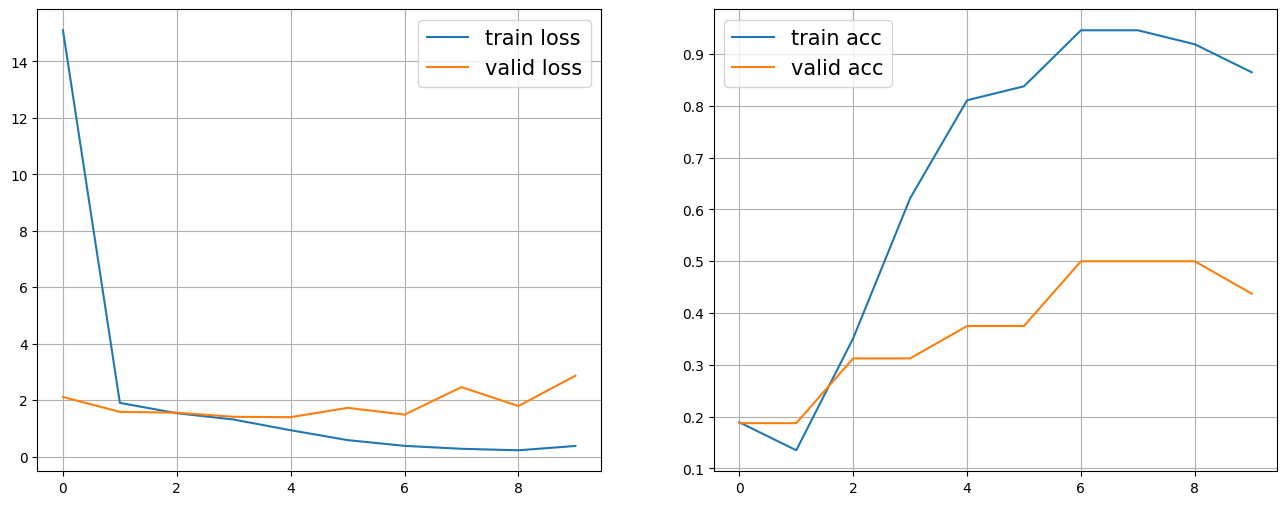

In [44]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [45]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

3/3 - 1s - loss: 2.3894 - accuracy: 0.6000 - 1s/epoch - 340ms/step


[2.3894095420837402, 0.6000000238418579]

## 8_Predict with Probability

In [46]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 1s 140ms/step
[0. 0. 1. 1.]
[1 1 1 1]


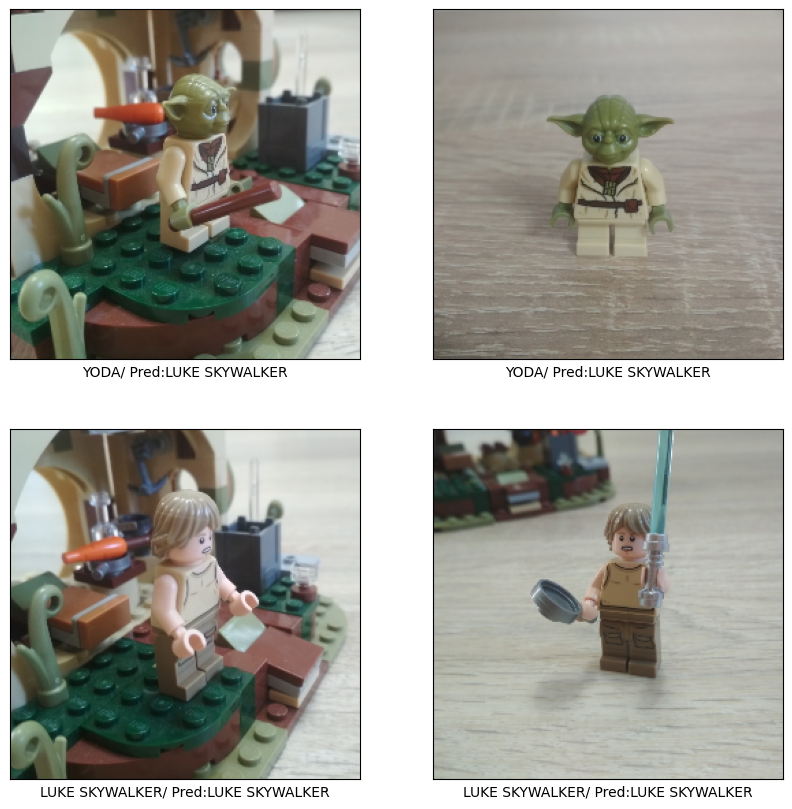

In [47]:
show_examples(test_batches[0], labels[0:4])

## TRANSFER LEARNING

## 1_Load Application Model

In [84]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

# try out different ones, e.g. MobileNetV2
#tl_model = tf.keras.applications.MobileNetV2()
#print(type(tl_model))
#tl_model.summary()

<class 'keras.src.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool

## 2_Normalize dataset

In [85]:
# get the preprocessing function of this model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Generate batches of tensor image data with real-time data augmentation.
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

## 3_Train,Validation,Test split

In [94]:
train_batches = train_gen.flow_from_directory(
    BASE_DIR+'/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR+'/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR+'/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


## 4_Plot to visualize some examples dataset

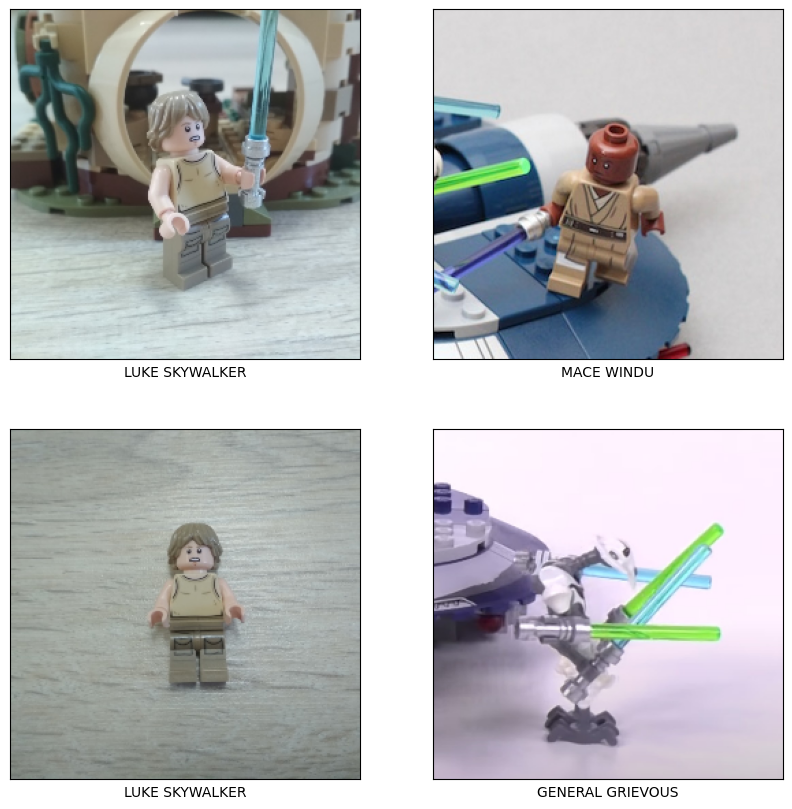

In [95]:
def show_examples(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays,
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show_examples(train_batch)

## 5_Build Model

## 5.1_Handle Original Model

In [96]:
# convert to Sequential model, omit the last layer
# this works with VGG16 because the structure is linear
model_vgg = Sequential()
for layer in vgg_model.layers[0:-1]:
    model_vgg.add(layer)

In [97]:
model_vgg.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## 5.2_Freeze(No training) Original Layers

In [98]:
# set trainable=False for all layers
# we don't want to train them again
for layer in model_vgg.layers:
    layer.trainable = False
model_vgg.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## 5.3_Modify Fully Connected Layers

In [99]:
# add a last classification layer for our use case with 5 classes
model_vgg.add(Dense(5))

## 6_Select Hyperparameters for Model

In [100]:
# loss and optimizer
loss = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=0.001)
metrics = ["accuracy"]

model_vgg.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [101]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history_vgg = model_vgg.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[early_stopping],
    epochs=epochs,
    verbose=2
)

Epoch 1/30
10/10 - 35s - loss: 2.4416 - accuracy: 0.3784 - val_loss: 1.1245 - val_accuracy: 0.6250 - 35s/epoch - 3s/step
Epoch 2/30
10/10 - 33s - loss: 0.1492 - accuracy: 0.9730 - val_loss: 1.1319 - val_accuracy: 0.6875 - 33s/epoch - 3s/step
Epoch 3/30
10/10 - 33s - loss: 0.0179 - accuracy: 1.0000 - val_loss: 1.0150 - val_accuracy: 0.6875 - 33s/epoch - 3s/step
Epoch 4/30
10/10 - 35s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.9674 - val_accuracy: 0.6875 - 35s/epoch - 4s/step
Epoch 5/30
10/10 - 39s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.9417 - val_accuracy: 0.6875 - 39s/epoch - 4s/step
Epoch 6/30
10/10 - 34s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.9248 - val_accuracy: 0.6875 - 34s/epoch - 3s/step
Epoch 7/30
10/10 - 33s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.9066 - val_accuracy: 0.6875 - 33s/epoch - 3s/step
Epoch 8/30
10/10 - 34s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8900 - val_accuracy: 0.7500 - 34s/epoch - 3s/step
Epoch 9/30
10/10 - 33s - loss: 0

In [102]:
model.save("transferlearning_lego_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7_Evaluation

In [106]:
model_vgg.evaluate(test_batches, verbose=2)

3/3 - 6s - loss: 0.2400 - accuracy: 0.8000 - 6s/epoch - 2s/step


[0.23998665809631348, 0.800000011920929]

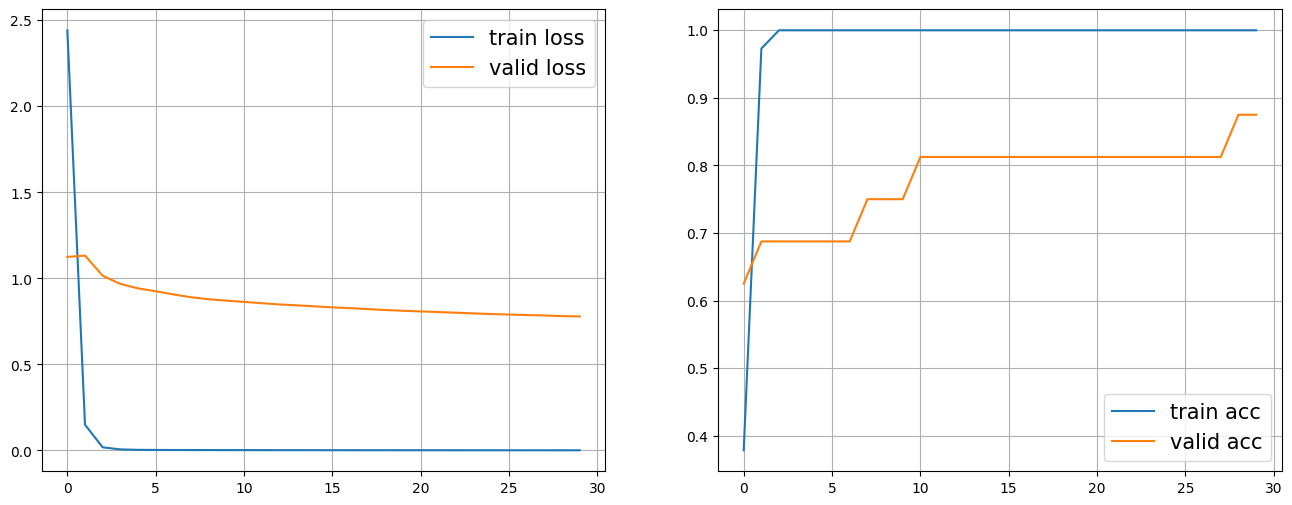

In [103]:
def plot_history(history):
  # plot loss and acc
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='valid loss')
  plt.grid()
  plt.legend(fontsize=15)
  # plot acc
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='train acc')
  plt.plot(history.history['val_accuracy'], label='valid acc')
  plt.grid()
  plt.legend(fontsize=15);

plot_history(history_vgg)

## 8_Predict with Probability

In [105]:
# make some predictions
predictions = model_vgg.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 8s 2s/step
[0. 0. 1. 1.]
[0 0 0 1]
